In [30]:
from mixmil.paths import DATA
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
import anndata as ad
from mixmil import MixMIL
import torch
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import scipy.stats as st
import random
from sklearn.linear_model import LinearRegression


import scanpy as sc

In [2]:
def to_device(el, device):
    """
    Move a nested structure of elements (dict, list, tuple, torch.Tensor, torch.nn.Module) to the specified device.

    Parameters:
    - el: Element or nested structure of elements to be moved to the device.
    - device (torch.device): The target device, such as 'cuda' for GPU or 'cpu' for CPU.

    Returns:
    - Transferred element(s) in the same structure: Elements moved to the specified device.
    """
    if isinstance(el, dict):
        return {k: to_device(v, device) for k, v in el.items()}
    elif isinstance(el, (list, tuple)):
        return [to_device(x, device) for x in el]
    elif isinstance(el, (torch.Tensor, torch.nn.Module)):
        return el.to(device)
    else:
        return el

## Prediction of selected genes

In [59]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready_variant_cat.h5ad')
# adata

/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [60]:
# tried genes:['DCTN5_twas_cat', 'CD33_cat'] #todo: EPH1A SPI1_twas_cat APOE_cat

In [64]:
sample_key = 'individualID'
gene_cat = 'APOE_twas_cat'
z_dim = 30
seed = 1

In [65]:
new_adata = ad.AnnData(X=adata.obsm['X_scVI'])
new_adata.obs = adata.obs.copy()
new_adata.obsm = adata.obsm.copy()

In [66]:
# check class imbalance
print(new_adata.obs.groupby(gene_cat)['individualID'].nunique())

APOE_twas_cat
0    115
1    215
2    106
Name: individualID, dtype: int64


In [45]:
# process class imbalance
# new_adata = new_adata[new_adata.obs[gene_cat] != 2]

In [67]:
# new_adata.obs.loc[:, 'CD33_cat'].replace(3, 2, inplace=True)
# new_adata.obs['CD33_cat'] = new_adata.obs['CD33_cat'].replace(3, 2)

In [68]:
# stratified sampling by category 
query_samples = []
query_proportion = 0.2
for cat in new_adata.obs[gene_cat].unique():
    adata_cat = new_adata[new_adata.obs[gene_cat] == cat]
    samples = list(np.unique(adata_cat.obs[sample_key]))
    n_samples = len(samples)
    random.seed(seed)
    query_samples.extend(random.sample(samples, int(n_samples * query_proportion)))
    
print(query_samples)

['R2645101', 'R6268135', 'R9419876', 'R9064073', 'R8760165', 'R1620679', 'R3589148', 'R2582129', 'R5739959', 'R9818080', 'R4956716', 'R5546461', 'R7334123', 'R4292728', 'R8971831', 'R3257830', 'R2264515', 'R5693901', 'R1105988', 'R4323608', 'R4906216', 'R6679530', 'R1015854', 'R2488731', 'R7095349', 'R9596785', 'R9253870', 'R1710143', 'R3863249', 'R2347173', 'R6292415', 'R9245150', 'R5927382', 'R6155093', 'R8044591', 'R5133113', 'R9489952', 'R3280186', 'R2079629', 'R6284240', 'R1234575', 'R5211056', 'R5766881', 'R7738727', 'R1028639', 'R8472815', 'R5924065', 'R3948425', 'R8704458', 'R3623803', 'R7596878', 'R2157677', 'R4581557', 'R9309271', 'R1214999', 'R1218460', 'R9540861', 'R6847727', 'R1073074', 'R9537646', 'R8451530', 'R3328867', 'R5629689', 'R9053141', 'R6759986', 'R3341095', 'R2494273', 'R6879714', 'R9566976', 'R8937093', 'R1748114', 'R3744330', 'R2144127', 'R6392007', 'R5656511', 'R6114572', 'R7698313', 'R5158294', 'R9239503', 'R3400726', 'R2086195', 'R6284795', 'R1287407', 'R5

In [69]:
# simple sampling 
# samples = list(np.unique(adata.obs[sample_key]))
# n_samples = len(samples)
# query_proportion = 0.2
# random.seed(seed)
# query_samples = random.sample(samples, int(n_samples * query_proportion))

# print(query_samples)

In [50]:
new_adata.obs[['msex', 'ceradsc']]

,msex,ceradsc
0,1.0,2.0
1,1.0,4.0
2,1.0,2.0
3,0.0,4.0
4,0.0,2.0
...,...,...
1581194,1.0,2.0
1581195,0.0,1.0
1581196,0.0,1.0
1581197,0.0,2.0


In [51]:
bag_covariates = (
    new_adata.obs[["individualID", "msex", "ceradsc"]]
    .drop_duplicates("individualID")
    .set_index("individualID")
    .loc[train_bags]
)

# F = torch.tensor(bag_covariates.values, dtype=torch.float32)


In [52]:
bag_covariates

,msex,ceradsc
individualID,,
R1015854,0.0,4.0
R1020037,0.0,4.0
R1028639,1.0,1.0
R1042011,0.0,4.0
R1042566,0.0,2.0
...,...,...
R9905342,0.0,1.0
R9907075,1.0,3.0
R9936070,1.0,2.0


In [77]:
# separate query and training adata
query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
adata = new_adata[~new_adata.obs[sample_key].isin(query_samples)].copy()
query.obs["ref"] = "query"
adata.obs["ref"] = "reference"

# sort index in both training adata and query 
idx = adata.obs[sample_key].sort_values().index
adata = adata[idx].copy()
idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

train_adata = adata.copy()
test_adata = query.copy()

# prepare train data
train_bags = train_adata.obs["individualID"].unique().tolist()
Xs = [torch.Tensor(train_adata[train_adata.obs["individualID"] == bag].X) for bag in train_bags]
# F = torch.Tensor([[1 if sex_dict[bag] == 1 else 0] for bag in train_bags]) # fixed effects for sex
F = torch.tensor(bag_covariates.values, dtype=torch.float32)
# F = torch.ones((len(train_bags), 1))

# prepare test data, following official train-test split
test_bags = test_adata.obs["individualID"].unique().tolist()
test_Xs = [torch.Tensor(test_adata[test_adata.obs["individualID"] == bag].X) for bag in test_bags]


In [78]:
Y = torch.Tensor(train_adata.obs[["individualID", gene_cat]].drop_duplicates().set_index("individualID").loc[train_bags].values)
test_Y = torch.Tensor(test_adata.obs[["individualID", gene_cat]].drop_duplicates().set_index("individualID").loc[test_bags].values)

# initialize model with mean model and Bernoulli likelihood
# model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=2)
model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="categorical", mean_field=True)
y_pred_mean = model.predict(test_Xs)
# y_pred_proba = torch.softmax(y_pred_mean, dim=1).numpy()
y_pred_labels = torch.argmax(y_pred_mean, dim=-1)
# print(
#     # "Test AUC:",
#     # round(roc_auc_score(test_Y, y_pred_mean), 3),
#     # "Spearman:",
#     # round(st.spearmanr(test_Y, y_pred_mean).correlation, 3),
#     "Spearman:",
#     round(st.spearmanr(test_Y, y_pred_labels).correlation, 3),
#     "Accuracy",
#     round(accuracy_score(test_Y, y_pred_labels), 3),
# )
print(
    "Macro_F1",
    f1_score(test_Y, y_pred_labels, average="macro"),
    "Spearman:",
    round(st.spearmanr(test_Y, y_pred_labels).correlation, 3),
)

/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro_F1 0.3002294893861159 Spearman: -0.085


In [79]:
# train model for 1000 epochs
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, Xs, F, Y, test_Xs, test_Y = to_device((model, Xs, F, Y, test_Xs, test_Y), device)
history = model.train(Xs, F, Y, n_epochs=1000, 
                      # batch_size = 128, 
                      # lr = 1e-4,
                     )
model.to("cpu")
test_Xs = [x.cpu() for x in test_Xs]
# y_pred = model.predict(test_Xs).cpu().numpy()
y_pred = model.predict(test_Xs)
y_true = test_Y.cpu().numpy()
y_pred_labels = torch.argmax(y_pred, dim=-1).cpu().numpy()
print('******************* After training *********************')
# print(gene_cat)
print(
    "Macro_F1",
    f1_score(y_true, y_pred_labels, average="macro"),
    "Spearman:",
    round(st.spearmanr(y_true, y_pred_labels).correlation, 3),
)

Epoch: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.78it/s]


******************* After training *********************
Spearman: 0.088 Accuracy 0.368


Macro_F1 0.3534150873281308 Spearman: 0.088


In [76]:
history

[{'loss': 208.6904754638672,
  'll': -1.0836963653564453,
  'kld': 207.60678100585938,
  'epoch': 1,
  'step': 0},
 {'loss': 313.538330078125,
  'll': -1.0743460655212402,
  'kld': 312.4639892578125,
  'epoch': 1,
  'step': 1},
 {'loss': 213.82273864746094,
  'll': -1.0225396156311035,
  'kld': 212.80020141601562,
  'epoch': 1,
  'step': 2},
 {'loss': 228.99134826660156,
  'll': -1.078847050666809,
  'kld': 227.91250610351562,
  'epoch': 1,
  'step': 3},
 {'loss': 265.63653564453125,
  'll': -1.065564751625061,
  'kld': 264.57098388671875,
  'epoch': 1,
  'step': 4},
 {'loss': 247.4052276611328,
  'll': -1.051176905632019,
  'kld': 246.3540496826172,
  'epoch': 1,
  'step': 5},
 {'loss': 214.61279296875,
  'll': -1.1143925189971924,
  'kld': 213.49839782714844,
  'epoch': 2,
  'step': 0},
 {'loss': 205.6029052734375,
  'll': -1.035271167755127,
  'kld': 204.567626953125,
  'epoch': 2,
  'step': 1},
 {'loss': 221.018310546875,
  'll': -1.0973637104034424,
  'kld': 219.9209442138672,
  '

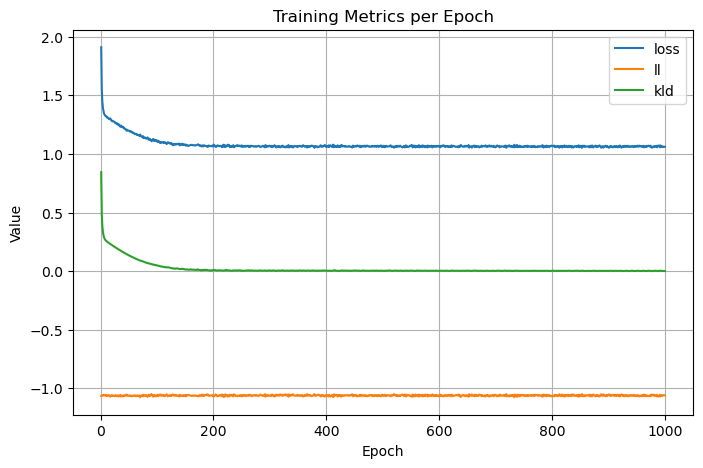

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Extract unique epochs
epochs = sorted(set(d['epoch'] for d in history))

# Compute average values per epoch
metrics = {m: [np.mean([d[m] for d in history if d['epoch'] == e]) for e in epochs] 
           for m in ['loss', 'll', 'kld']}

# Plot
plt.figure(figsize=(8, 5))
for metric, values in metrics.items():
    plt.plot(epochs, values, label=metric)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
# check class imbalance
gene_cat = 'DCTN5_twas'
print(new_adata.obs.groupby(gene_cat)['individualID'].nunique())

Y = torch.Tensor(train_adata.obs[["individualID", gene_cat]].drop_duplicates().set_index("individualID").loc[train_bags].values)
# test_Y = torch.Tensor(test_adata.obs[["individualID", gene_cat]].drop_duplicates().set_index("individualID").loc[test_bags].values)

X_m = np.concatenate([x.numpy().mean(axis=0, keepdims=True) for x in Xs])
F_X_m = np.concatenate([F, X_m], axis=1)
mm = LinearRegression(fit_intercept=False).fit(F_X_m, Y.numpy())

mm_preds = mm.predict(F_X_m).ravel()
Y_flat = Y.numpy().ravel()

print(
    "Spearman:",
    round(st.spearmanr(Y_flat, mm_preds).correlation, 3),
)

DCTN5_twas
-6.82     15
-3.41     80
 0.00    150
Name: individualID, dtype: int64
Spearman: 0.408


In [64]:
sd["posterior.mu"].shape

torch.Size([1, 80])

In [67]:
beta.shape

torch.Size([1, 30])

In [68]:
model = MixMIL(30, 1, 1, likelihood="normal")
sd = model.state_dict()
for name, param in sd.items():
    print(name, param.shape)
sd["alpha"] = torch.tensor(mm.coef_.ravel()[0]).reshape(1, 1)
beta = mm.coef_.ravel()[1:]
u = X_m.dot(beta)
beta = u.std() * beta / np.sqrt((beta**2).mean())
beta = torch.tensor(beta).reshape(1, -1)
sd["posterior.mu"] = torch.cat([sd["posterior.mu"][:, :30], beta], dim=1)
model.load_state_dict(sd)

alpha torch.Size([1, 1])
log_sigma_u torch.Size([1, 1])
log_sigma_z torch.Size([1, 1])
log_scale torch.Size([])
posterior.mu torch.Size([1, 60])
posterior.cov_factor torch.Size([1, 60, 60])
posterior.cov_logdiag torch.Size([1, 60])


<All keys matched successfully>

In [69]:
hist = model.train(Xs, F, Y, n_epochs=1_000)

Epoch: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [04:49<00:00,  3.46it/s]


In [70]:
hdf = pd.DataFrame(hist)

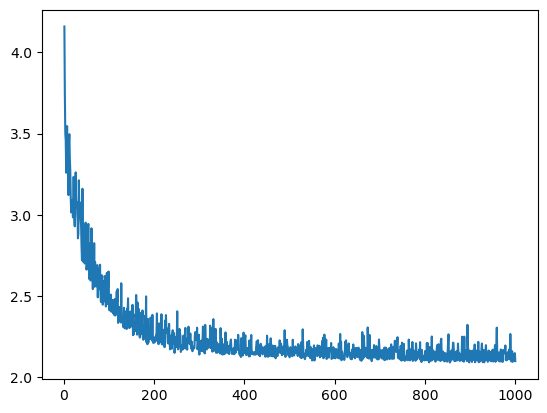

In [71]:
plt.plot(hdf.groupby("epoch").loss.mean())

In [72]:
pred = model.predict(test_Xs)
pred = pred.detach().cpu().numpy()
st.pearsonr(test_Y.ravel(), pred.ravel()), st.spearmanr(test_Y.ravel(), pred.ravel())

(PearsonRResult(statistic=-0.004186766454949975, pvalue=0.97927374),
 SignificanceResult(statistic=0.020670184440819597, pvalue=0.8979319341818668))

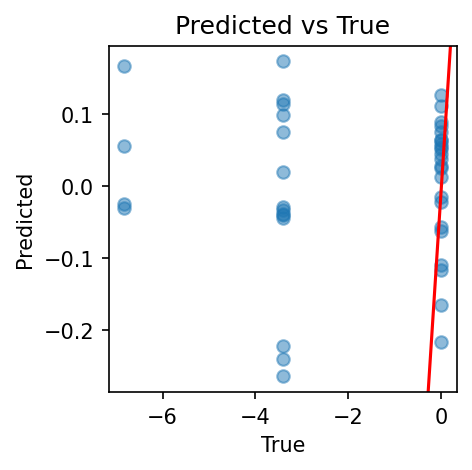

In [73]:
fig, ax = plt.subplots(figsize=(3,3), dpi=150)
ax.scatter(test_Y.ravel(), pred.ravel(), alpha=0.5)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.set_title("Predicted vs True")
ax.axline((0,0), slope=1, color="red")

## Mass prediction

In [2]:
adata = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/all_ready_variant_cat.h5ad')
adata

/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1581199 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', '_scvi_batch', '_scvi_labels', 'AD', 'apoe_label', 'specimenID', 'ABCA1', 'ABCA7', 'ACE', 'ADAM17', 'ADAMTS1', 'ADGRG4', 'ANK3', 'ANKH', 'APH1B', 'APP', 'BCKDK', 'BIN1', 'BLNK', 'CASS4', 'CD2AP', 'CD33', 'CLNK', 'CLU', 'COX7C', 'CR1', 'CTSB', 'CTSH', 'DOC2A', 'EED', 'EPDR1', 'EPHA1', 'FERMT2', 'FOXF1', 'GRN', 'HLA-DQA1', 'HS3ST5', 'ICA1', 'IGH gene cluster', 'IL34', 'INPP5D', 'LILRB2', 'MAF', 'MID1', 'MINDY2', 'MME', 'MS4A4A', 'MTM1', 'MYO15A', 'NLGN4X', 'PLCG2', 'PLEKHA1', 'PRDM7', 'PRKD3', 'PTK2B', 'RASGEF1C', 'RBCK1', 'RHOH', 'SCIMP', 'SEC61G', 'SHARPIN', 'SIGLEC11', 'SLC24A4',

In [20]:
adata.obs.dtypes

nCount_RNA           float64
nFeature_RNA           int32
nCount_SCT           float64
nFeature_SCT           int32
batch               category
                      ...   
ZNF785_twas_cat        int64
ZSCAN21_twas_cat       int64
ZSCAN26_twas_cat       int64
ZSCAN31_twas_cat       int64
ZYX_twas_cat           int64
Length: 504, dtype: object

In [3]:
# adata.obs = adata.obs.reset_index(drop = True)

## risk score predictions

In [3]:
def to_device(el, device):
    """
    Move a nested structure of elements (dict, list, tuple, torch.Tensor, torch.nn.Module) to the specified device.

    Parameters:
    - el: Element or nested structure of elements to be moved to the device.
    - device (torch.device): The target device, such as 'cuda' for GPU or 'cpu' for CPU.

    Returns:
    - Transferred element(s) in the same structure: Elements moved to the specified device.
    """
    if isinstance(el, dict):
        return {k: to_device(v, device) for k, v in el.items()}
    elif isinstance(el, (list, tuple)):
        return [to_device(x, device) for x in el]
    elif isinstance(el, (torch.Tensor, torch.nn.Module)):
        return el.to(device)
    else:
        return el

In [4]:
cats = adata.obs.iloc[:, 270:].columns
cats

Index(['ABCA1_cat', 'ABCA7_cat', 'ACE_cat', 'ADAM17_cat', 'ADAMTS1_cat',
       'ADGRG4_cat', 'ANK3_cat', 'ANKH_cat', 'APH1B_cat', 'APP_cat',
       ...
       'YPEL3_twas_cat', 'ZKSCAN1_twas_cat', 'ZKSCAN3_twas_cat',
       'ZNF232_twas_cat', 'ZNF608_twas_cat', 'ZNF785_twas_cat',
       'ZSCAN21_twas_cat', 'ZSCAN26_twas_cat', 'ZSCAN31_twas_cat',
       'ZYX_twas_cat'],
      dtype='object', length=234)

In [5]:
sample_key = 'individualID'
# classification_keys = ["TRAPPC6A_twas_cat"]
z_dim = 30
# categorical_covariate_keys = classification_keys + [sample_key]
seed = 0

In [6]:
new_adata = ad.AnnData(X=adata.obsm['X_scVI'])
new_adata.obs = adata.obs.copy()
new_adata.obsm = adata.obsm.copy()

In [8]:
samples = np.unique(adata.obs[sample_key])
n_samples = len(samples)
query_proportion = 0.2
rng = np.random.default_rng(seed)
query_samples = rng.choice(samples, int(n_samples * query_proportion), replace=False)

# separate query and training adata
query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
adata = new_adata[~new_adata.obs[sample_key].isin(query_samples)].copy()
query.obs["ref"] = "query"
adata.obs["ref"] = "reference"

# sort index in both training adata and query 
idx = adata.obs[sample_key].sort_values().index
adata = adata[idx].copy()
idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

train_adata = adata.copy()
test_adata = query.copy()

# prepare train data
train_bags = train_adata.obs["individualID"].unique().tolist()
Xs = [torch.Tensor(train_adata[train_adata.obs["individualID"] == bag].X) for bag in train_bags]
# F = torch.Tensor([[1 if sex_dict[bag] == 1 else 0] for bag in train_bags]) # fixed effects for sex
F = torch.ones((len(train_bags), 1))

# prepare test data, following official train-test split
test_bags = test_adata.obs["individualID"].unique().tolist()
test_Xs = [torch.Tensor(test_adata[test_adata.obs["individualID"] == bag].X) for bag in test_bags]


In [10]:
predictable_genes = []
for gene_cat in cats:
    classification_keys = [gene_cat]
    # check class imbalance
    print(new_adata.obs.groupby(gene_cat)['individualID'].nunique())

    if (new_adata.obs.groupby(gene_cat)['individualID'].nunique().min() < 5) or (len(new_adata.obs.groupby(gene_cat)['individualID'].nunique()) < 2):
        continue
    
    Y = torch.Tensor(train_adata.obs[["individualID", gene_cat]].drop_duplicates().set_index("individualID").loc[train_bags].values)
    test_Y = torch.Tensor(test_adata.obs[["individualID", gene_cat]].drop_duplicates().set_index("individualID").loc[test_bags].values)

    # initialize model with mean model and Bernoulli likelihood
    # model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=2)
    model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="categorical")
    y_pred_mean = model.predict(test_Xs)
    # y_pred_proba = torch.softmax(y_pred_mean, dim=1).numpy()
    y_pred_labels = torch.argmax(y_pred_mean, dim=-1)
    print(
        # "Test AUC:",
        # round(roc_auc_score(test_Y, y_pred_mean), 3),
        # "Spearman:",
        # round(st.spearmanr(test_Y, y_pred_mean).correlation, 3),
        "Spearman:",
        round(st.spearmanr(test_Y, y_pred_labels).correlation, 3),
        "Accuracy",
        round(accuracy_score(test_Y, y_pred_labels), 3),
    )
    if round(st.spearmanr(test_Y, y_pred_labels).correlation, 3)>0.15:
        predictable_genes.append(gene_cat)

ABCA1_cat
0    329
1    100
2      7
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.048 Accuracy 0.464
ABCA7_cat
0    177
1    211
2     48
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.052 Accuracy 0.42
ACE_cat
0     68
1    199
2    169
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.152 Accuracy 0.246
ADAM17_cat
0    329
1     99
2      8
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.059 Accuracy 0.449
ADAMTS1_cat
0     37
1    176
2    223
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.167 Accuracy 0.449
ADGRG4_cat
0     71
1    120
2    245
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.078 Accuracy 0.42
ANK3_cat
0     74
1    201
2    161
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.036 Accuracy 0.348
ANKH_cat
0    371
1     62
2      3
Name: individualID, dtype: int64
APH1B_cat
0    323
1    107
2      6
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.075 Accuracy 0.449
APP_cat
0     83
1    220
2    133
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.157 Accuracy 0.304
BCKDK_cat
0     32
1    198
2    206
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.061 Accuracy 0.362
BIN1_cat
0    148
1    227
2     61
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.006 Accuracy 0.42
CASS4_cat
0      3
1     72
2    361
Name: individualID, dtype: int64
CD2AP_cat
0    247
1    156
2     33
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.012 Accuracy 0.478
CD33_cat
0     47
1    180
2      1
3    208
Name: individualID, dtype: int64
CLNK_cat
0    229
1    171
2     36
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.155 Accuracy 0.42
CLU_cat
0     63
1    217
2    156
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.027 Accuracy 0.362
COX7C_cat
0    278
1    138
2     20
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.027 Accuracy 0.362
CR1_cat
0    294
1    125
2     17
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.031 Accuracy 0.449
CTSB_cat
0    391
1     44
2      1
Name: individualID, dtype: int64
CTSH_cat
0      8
1     92
2    336
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.03 Accuracy 0.232
DOC2A_cat
0     62
1    223
2    151
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.107 Accuracy 0.391
EED_cat
0     56
1    213
2    167
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.134 Accuracy 0.348
EPDR1_cat
0     54
1    191
2    191
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.042 Accuracy 0.333
EPHA1_cat
0     66
1    196
2    174
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.228 Accuracy 0.348
FERMT2_cat
0    367
1     66
2      3
Name: individualID, dtype: int64
GRN_cat
0    209
1    188
2     39
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.071 Accuracy 0.391
HLA-DQA1_cat
0      5
1    114
2    317
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Spearman: -0.064 Accuracy 0.464
HS3ST5_cat
0    188
1    193
2     55
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.06 Accuracy 0.319
ICA1_cat
0    356
1     75
2      5
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.095 Accuracy 0.391
IGH gene cluster_cat
0      2
1      7
2     53
3     34
4    172
5    131
6     37
Name: individualID, dtype: int64
IL34_cat
0    349
1     80
2      7
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.115 Accuracy 0.478
INPP5D_cat
0     29
1    164
2    243
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.098 Accuracy 0.406
LILRB2_cat
0    220
1    189
2     27
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.061 Accuracy 0.435
MAF_cat
0     58
1    215
2    163
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.086 Accuracy 0.304
MINDY2_cat
0     21
1    204
2    211
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.046 Accuracy 0.406
MME_cat
0      2
1     48
2    386
Name: individualID, dtype: int64
MS4A4A_cat
0     63
1    226
2    147
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.078 Accuracy 0.493
MTM1_cat
0    385
1     39
2     12
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.147 Accuracy 0.362
MYO15A_cat
0      3
1     97
2    336
Name: individualID, dtype: int64
NLGN4X_cat
0      1
1      5
2    430
Name: individualID, dtype: int64
PLCG2_cat
0     66
1    212
2    158
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.069 Accuracy 0.377
PLEKHA1_cat
0    114
1    201
2    121
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.093 Accuracy 0.333
PRDM7_cat
0    376
1     58
2      2
Name: individualID, dtype: int64
PRKD3_cat
0    315
1    116
2      5
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.098 Accuracy 0.42
PTK2B_cat
0    182
1    195
2     59
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.102 Accuracy 0.478
RASGEF1C_cat
0    348
1     86
2      2
Name: individualID, dtype: int64
RBCK1_cat
0     30
1    137
2    269
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.104 Accuracy 0.275
RHOH_cat
0    218
1    166
2     52
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.261 Accuracy 0.275
SCIMP_cat
0    346
1     86
2      4
Name: individualID, dtype: int64
SEC61G_cat
0      6
1     79
2    351
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.025 Accuracy 0.406
SHARPIN_cat
0    372
1     58
2      6
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Spearman: -0.097 Accuracy 0.391
SIGLEC11_cat
0    261
1    146
2     29
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.123 Accuracy 0.319
SLC24A4_cat
0    19
1    24
2    99
3    92
4    94
5    87
6    21
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.025 Accuracy 0.174
SLC2A4RG_cat
0     16
1    129
2    291
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.129 Accuracy 0.348
SLC9A7_cat
0    175
1    140
2    121
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.048 Accuracy 0.304
SNX1_cat
0    273
1    152
2     11
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.233 Accuracy 0.565
SORL1_cat
0      2
1     25
2    401
3      7
4      1
Name: individualID, dtype: int64
SPDYE3_cat
0     47
1    196
2    193
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.077 Accuracy 0.275
SPI1_cat
0    179
1    194
2     63
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.03 Accuracy 0.275
SPPL2A_cat
0     70
1    194
2    172
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.112 Accuracy 0.261
TMEM106B_cat
0     92
1    211
2    133
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.307 Accuracy 0.435
TNIP1_cat
0     40
1    208
2    188
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.002 Accuracy 0.391
TPCN1_cat
0    380
1     55
2      1
Name: individualID, dtype: int64
TREML2_cat
0    436
Name: individualID, dtype: int64
TSPAN14_cat
0     24
1    121
2    291
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.111 Accuracy 0.42
TSPOAP1_cat
0     75
1    228
2    133
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.014 Accuracy 0.377
UMAD1_cat
0    164
1    201
2     71
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.241 Accuracy 0.406
UNC5CL_cat
0      7
1    121
2    308
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.113 Accuracy 0.42
USP6NL_cat
0    130
1    218
2     88
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.08 Accuracy 0.348
WNT3_cat
0     20
1    137
2    279
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.116 Accuracy 0.391
ZNF280C_cat
0    207
1    137
2     92
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.07 Accuracy 0.435
AC004797.1_twas_cat
0    163
1    200
2     73
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.008 Accuracy 0.391
AC005225.2_twas_cat
0     73
1    215
2    148
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.077 Accuracy 0.391
AC008105.3_twas_cat
0      4
1     55
2    377
Name: individualID, dtype: int64
AC010976.1_twas_cat
0    191
1    189
2     56
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.104 Accuracy 0.304
AC013643.2_twas_cat
0     25
1    153
2    258
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.063 Accuracy 0.42
AC087500.1_twas_cat
0    308
1    116
2     12
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.035 Accuracy 0.507
AC097662.1_twas_cat
0     36
1    186
2    214
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.031 Accuracy 0.29
AC139887.2_twas_cat
0     30
1    174
2    232
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.117 Accuracy 0.391
ACE_twas_cat
0    164
1    202
2     70
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.013 Accuracy 0.275
ACOT2_twas_cat
0     34
1    146
2    256
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.073 Accuracy 0.449
ADAM10_twas_cat
0    214
1    195
2     27
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.029 Accuracy 0.391
AL049637.1_twas_cat
0    358
1     76
2      2
Name: individualID, dtype: int64
AL162431.1_twas_cat
0    153
1    229
2     54
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.005 Accuracy 0.304
AL162511.1_twas_cat
0     41
1    130
2    265
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.023 Accuracy 0.406
AL596218.1_twas_cat
0     17
1    126
2    293
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.031 Accuracy 0.449
AP001439.1_twas_cat
0    129
1    136
2     63
3     69
4     36
5      3
Name: individualID, dtype: int64
AP4M1_twas_cat
0     36
1     79
2    100
3     47
4    108
5     66
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.117 Accuracy 0.072
APH1B_twas_cat
0    323
1    107
2      6
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.075 Accuracy 0.449
APOC1_twas_cat
0    102
1    218
2    116
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.247 Accuracy 0.377
APOE_twas_cat
0    115
1    215
2    106
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.21 Accuracy 0.362
ARHGAP31_twas_cat
0     27
1    162
2    247
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.082 Accuracy 0.304
ARL17B_twas_cat
0     18
1      3
2    139
3    276
Name: individualID, dtype: int64
ASPHD1_twas_cat
0    102
1    212
2    122
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.054 Accuracy 0.391
ATP5MC2_twas_cat
0    235
1    177
2     24
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.048 Accuracy 0.406
BCL7C_twas_cat
0    237
1    164
2     35
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.013 Accuracy 0.304
BIN1_twas_cat
0     61
1     55
2    162
3     84
4     74
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.112 Accuracy 0.246
C1QBP_twas_cat
0      7
1     73
2    356
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.201 Accuracy 0.464
C1QTNF4_twas_cat
0    182
1    193
2     61
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.091 Accuracy 0.348
CARF_twas_cat
0    344
1      2
2     75
3     15
Name: individualID, dtype: int64
CASS4_twas_cat
0      3
1     74
2    359
Name: individualID, dtype: int64
CASTOR3_twas_cat
0    115
1    197
2    124
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.043 Accuracy 0.246
CBY1_twas_cat
0    206
1    199
2     31
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.142 Accuracy 0.348
CCDC189_twas_cat
0    167
1    204
2     65
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.035 Accuracy 0.333
CCDC6_twas_cat
0     23
1    124
2    154
3     68
4     64
5      3
Name: individualID, dtype: int64
CCDC85A_twas_cat
0    124
1    228
2     84
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.089 Accuracy 0.29
CCNT2_twas_cat
0    130
1    210
2     96
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.019 Accuracy 0.348
CCNT2-AS1_twas_cat
0     96
1    108
2    102
3    130
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.029 Accuracy 0.261
CD2AP_twas_cat
0     40
1    170
2     32
3    194
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.099 Accuracy 0.348
CD2BP2_twas_cat
0     96
1    221
2    119
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.092 Accuracy 0.362
CDK10_twas_cat
0     48
1     10
2     11
3    163
4     22
5    131
6     51
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.05 Accuracy 0.159
CELF1_twas_cat
0     64
1    190
2    182
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.031 Accuracy 0.304
CEP89_twas_cat
0     69
1    219
2    148
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.062 Accuracy 0.232
CLASRP_twas_cat
0     73
1    219
2    144
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.015 Accuracy 0.377
CLPTM1_twas_cat
0    148
1    210
2     78
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.054 Accuracy 0.29
CLU_twas_cat
0     75
1    103
2    130
3     83
4     32
5     13
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.082 Accuracy 0.232
CMC1_twas_cat
0    347
1     83
2      6
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Spearman: -0.007 Accuracy 0.507
COG7_twas_cat
0    273
1    137
2     26
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.076 Accuracy 0.478
CPNE7_twas_cat
0    347
1     80
2      9
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.079 Accuracy 0.362
CPSF6_twas_cat
0     38
1     57
2     21
3    132
4     80
5    108
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.346 Accuracy 0.13
CR1_twas_cat
0     17
1    126
2    293
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.031 Accuracy 0.449
CRHR1_twas_cat
0     18
1    143
2    275
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.165 Accuracy 0.391
CSGALNACT2_twas_cat
0    284
1    138
2     14
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.109 Accuracy 0.217
CTSB_twas_cat
0      3
1     78
2    355
Name: individualID, dtype: int64
CTSH_twas_cat
0      6
1     99
2    331
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Spearman: -0.011 Accuracy 0.391
DCTN5_twas_cat
0     25
1    144
2    267
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.351 Accuracy 0.348
DHX33_twas_cat
0    365
1     70
2      1
Name: individualID, dtype: int64
DLG2_twas_cat
0     39
1    160
2    237
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.245 Accuracy 0.29
DRC3_twas_cat
0     29
1    171
2    204
3     31
4      1
Name: individualID, dtype: int64
EFCAB13_twas_cat
0    108
1    201
2    127
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.062 Accuracy 0.348
EGFR_twas_cat
0    351
1     79
2      6
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.025 Accuracy 0.406
EML2_twas_cat
0    142
1    216
2     78
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.083 Accuracy 0.333
EPHX2_twas_cat
0    332
1     97
2      7
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.072 Accuracy 0.42
ERCC2_twas_cat
0     96
1    214
2    126
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.097 Accuracy 0.377
ETS2_twas_cat
0     34
1    182
2    220
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.052 Accuracy 0.377
FAM227A_twas_cat
0     56
1    209
2    171
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.027 Accuracy 0.406
FAM241A_twas_cat
0     69
1    203
2    164
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.106 Accuracy 0.275
FCER1G_twas_cat
0    255
1    153
2     28
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.119 Accuracy 0.507
FERMT2_twas_cat
0     93
1     84
2     13
3    146
4     56
5     44
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.056 Accuracy 0.159
FIBP_twas_cat
0    272
1    151
2     13
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.188 Accuracy 0.348
FMNL1_twas_cat
0      4
1     55
2    377
Name: individualID, dtype: int64
FNIP2_twas_cat
0    184
1    191
2     61
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.12 Accuracy 0.362
GGA2_twas_cat
0      1
1     29
2    234
3    130
4     39
5      3
Name: individualID, dtype: int64
GPATCH8_twas_cat
0    163
1    214
2     59
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.194 Accuracy 0.406
GRN_twas_cat
0     39
1    188
2    209
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.071 Accuracy 0.391
HEATR4_twas_cat
0     86
1    222
2    128
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.058 Accuracy 0.406
HOOK2_twas_cat
0    189
1    207
2     40
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.006 Accuracy 0.406
HTRA1_twas_cat
0    315
1    108
2     13
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.047 Accuracy 0.435
ICA1L_twas_cat
0    345
1     76
2     15
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.094 Accuracy 0.391
IL34_twas_cat
0     84
1    231
2    121
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.18 Accuracy 0.551
INO80E_twas_cat
0    102
1     29
2    182
3     31
4     92
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.129 Accuracy 0.348
INPP5D_twas_cat
0     19
1    144
2    273
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.026 Accuracy 0.391
IPPK_twas_cat
0     50
1    196
2    190
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.015 Accuracy 0.319
ITGA9_twas_cat
0    149
1    211
2     76
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.141 Accuracy 0.406
ITGA9-AS1_twas_cat
0    149
1    211
2     76
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.141 Accuracy 0.406
ITGAX_twas_cat
0      5
1     96
2    335
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.005 Accuracy 0.391
JAZF1_twas_cat
0     25
1    142
2    269
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.068 Accuracy 0.333
KAT8_twas_cat
0     87
1    108
2    123
3     23
4     72
5     23
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.064 Accuracy 0.072
KCTD13_twas_cat
0    436
Name: individualID, dtype: int64
LDB3_twas_cat
0    316
1    112
2      8
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.064 Accuracy 0.42
MAF_twas_cat
0     29
1    174
2    233
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.227 Accuracy 0.333
MALT1_twas_cat
0    350
1     83
2      3
Name: individualID, dtype: int64
MAP3K14_twas_cat
0    318
1    111
2      7
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.05 Accuracy 0.464
MAPT_twas_cat
0     20
1    137
2    279
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.19 Accuracy 0.435
MAPT-AS1_twas_cat
0    276
1    140
2     20
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.249 Accuracy 0.522
MFF_twas_cat
0    214
1    186
2     36
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.031 Accuracy 0.29
MGAT5_twas_cat
0     47
1    182
2    207
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.09 Accuracy 0.333
MINDY2_twas_cat
0    170
1    223
2     43
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.04 Accuracy 0.435
MS4A4A_twas_cat
0    194
1    191
2     51
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.013 Accuracy 0.232
MS4A4E_twas_cat
0    166
1    201
2     69
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.158 Accuracy 0.348
MS4A6A_twas_cat
0    202
1    186
2     48
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.009 Accuracy 0.275
MS4A7_twas_cat
0    191
1    202
2     43
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.143 Accuracy 0.232
MTCH2_twas_cat
0    172
1     11
2    197
3     56
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.102 Accuracy 0.217
MYT1L_twas_cat
0    217
1    179
2     40
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.005 Accuracy 0.362
NAE1_twas_cat
0     52
1    195
2    189
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.024 Accuracy 0.261
NDUFS2_twas_cat
0      7
1    107
2    322
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.154 Accuracy 0.377
NECTIN2_twas_cat
0     15
1     84
2     68
3    104
4    130
5     35
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.087 Accuracy 0.101
NEK10_twas_cat
0    233
1    181
2     22
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.02 Accuracy 0.377
NRF1_twas_cat
0    210
1    186
2     40
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.005 Accuracy 0.261
NUP62_twas_cat
0    196
1    186
2     54
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.178 Accuracy 0.304
PGBD1_twas_cat
0     15
1    136
2    285
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.1 Accuracy 0.391
PICALM_twas_cat
0    167
1    140
2     73
3     56
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.056 Accuracy 0.348
PITPNA_twas_cat
0     30
1    133
2     29
3    169
4     69
5      6
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.006 Accuracy 0.203
PLEKHA1_twas_cat
0    120
1    201
2    115
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.117 Accuracy 0.319
PLEKHM1_twas_cat
0    280
1    136
2     20
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.248 Accuracy 0.449
PPP1R37_twas_cat
0     38
1    162
2    236
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.105 Accuracy 0.348
PSMD12_twas_cat
0    263
1    156
2     17
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.022 Accuracy 0.406
PTCD3_twas_cat
0     61
1    195
2    180
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.011 Accuracy 0.304
PTK2B_twas_cat
0    160
1    205
2     71
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.012 Accuracy 0.377
RABEP1_twas_cat
0     23
1    324
2     77
3     12
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.08 Accuracy 0.275
RAPGEF2_twas_cat
0     69
1    212
2    155
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.054 Accuracy 0.29
RASA1_twas_cat
0    139
1     69
2    131
3     97
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.065 Accuracy 0.261
RASGEF1C_twas_cat
0      2
1     88
2    346
Name: individualID, dtype: int64
RBCK1_twas_cat
0    269
1    137
2     30
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.104 Accuracy 0.275
REEP2_twas_cat
0     18
1    156
2    262
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.082 Accuracy 0.391
RHOH_twas_cat
0     16
1    126
2    294
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.215 Accuracy 0.391
RIN3_twas_cat
0     96
1    229
2    111
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.257 Accuracy 0.304
RPAIN_twas_cat
0      6
1     55
2    375
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.208 Accuracy 0.435
SCIMP_twas_cat
0     19
1    142
2    275
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.162 Accuracy 0.449
SCRIB_twas_cat
0      4
1     56
2    376
Name: individualID, dtype: int64
SEZ6L2_twas_cat
0     92
1    217
2    127
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.154 Accuracy 0.362
SLC35G2_twas_cat
0    202
1    185
2     49
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.137 Accuracy 0.377
SNRPC_twas_cat
0    195
1    185
2     56
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.118 Accuracy 0.362
SPI1_twas_cat
0    197
1    190
2     49
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.203 Accuracy 0.478
SPINDOC_twas_cat
0      6
1    106
2    324
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.066 Accuracy 0.261
SRA1_twas_cat
0    101
1    210
2    125
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.143 Accuracy 0.348
STAG3_twas_cat
0     39
1     60
2    134
3     85
4    114
5      4
Name: individualID, dtype: int64
STX6_twas_cat
0    153
1    229
2     54
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.005 Accuracy 0.304
SUN2_twas_cat
0    133
1    221
2     82
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.026 Accuracy 0.246
SYT14_twas_cat
0    284
1    125
2     27
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.135 Accuracy 0.377
TMEM163_twas_cat
0     89
1    197
2    150
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.121 Accuracy 0.435
TMEM219_twas_cat
0    127
1    217
2     92
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.154 Accuracy 0.362
TNFRSF21_twas_cat
0      1
1     52
2    383
Name: individualID, dtype: int64
TNIP1_twas_cat
0    188
1    208
2     40
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.002 Accuracy 0.391
TP53INP1_twas_cat
0    117
1    204
2    115
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.057 Accuracy 0.362
TPCN1_twas_cat
0    378
1     57
2      1
Name: individualID, dtype: int64
TRAPPC6A_twas_cat
0     14
1    166
2    256
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.045 Accuracy 0.348
TREM2_twas_cat
0    187
1    198
2     51
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.032 Accuracy 0.261
TRIM24_twas_cat
0     64
1    196
2    176
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.18 Accuracy 0.261
TRIM27_twas_cat
0     43
1    192
2    201
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.215 Accuracy 0.377
UHRF1BP1_twas_cat
0     53
1    177
2     15
3    191
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.001 Accuracy 0.232
USP6NL_twas_cat
0      7
1     11
2     48
3     71
4    123
5    131
6     45
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.143 Accuracy 0.304
WDR12_twas_cat
0    345
1     76
2     15
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.094 Accuracy 0.391
YPEL3_twas_cat
0     95
1    216
2    125
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.075 Accuracy 0.406
ZKSCAN1_twas_cat
0      6
1    102
2    114
3    120
4     86
5      8
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.044 Accuracy 0.275
ZKSCAN3_twas_cat
0     60
1    202
2    174
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.083 Accuracy 0.333
ZNF232_twas_cat
0    367
1     64
2      5
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Spearman: -0.031 Accuracy 0.522
ZNF608_twas_cat
0    192
1    179
2     65
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.048 Accuracy 0.42
ZNF785_twas_cat
0     23
1    130
2    283
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.049 Accuracy 0.333
ZSCAN21_twas_cat
0     89
1    212
2    135
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.015 Accuracy 0.29
ZSCAN26_twas_cat
0     71
1    188
2     16
3    161
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.068 Accuracy 0.246
ZSCAN31_twas_cat
0     13
1    168
2    186
3     54
4      9
5      6
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: -0.121 Accuracy 0.246
ZYX_twas_cat
0     90
1    198
2    148
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.249 Accuracy 0.377


In [11]:
predictable_genes

['ADAMTS1_cat',
 'CLNK_cat',
 'EPHA1_cat',
 'SNX1_cat',
 'TMEM106B_cat',
 'UMAD1_cat',
 'CRHR1_twas_cat',
 'DCTN5_twas_cat',
 'DLG2_twas_cat',
 'GPATCH8_twas_cat',
 'IL34_twas_cat',
 'MAPT_twas_cat',
 'MAPT-AS1_twas_cat',
 'MS4A4E_twas_cat',
 'NDUFS2_twas_cat',
 'PLEKHM1_twas_cat',
 'SCIMP_twas_cat',
 'SEZ6L2_twas_cat',
 'SPI1_twas_cat',
 'TMEM219_twas_cat',
 'ZYX_twas_cat']

In [32]:
predictable_genes

['ABCA1_cat',
 'CLU_cat',
 'COX7C_cat',
 'GRN_cat',
 'ICA1_cat',
 'INPP5D_cat',
 'MAF_cat',
 'TMEM106B_cat',
 'TSPOAP1_cat',
 'AC010976.1_twas_cat',
 'AL162511.1_twas_cat',
 'AL596218.1_twas_cat',
 'ARHGAP31_twas_cat',
 'BIN1_twas_cat',
 'CD2BP2_twas_cat',
 'CLU_twas_cat',
 'CR1_twas_cat',
 'GPATCH8_twas_cat',
 'GRN_twas_cat',
 'INPP5D_twas_cat',
 'PPP1R37_twas_cat',
 'PTCD3_twas_cat',
 'RPAIN_twas_cat',
 'SPI1_twas_cat',
 'TMEM163_twas_cat',
 'UHRF1BP1_twas_cat']

In [12]:
for gene_cat in predictable_genes:
    classification_keys = [gene_cat]
    # check class imbalance
    print(new_adata.obs.groupby(gene_cat)['individualID'].nunique())

    if (new_adata.obs.groupby(gene_cat)['individualID'].nunique().min() < 5) or (len(new_adata.obs.groupby(gene_cat)['individualID'].nunique()) < 2):
        continue

    # prepare train data
    train_bags = train_adata.obs["individualID"].unique().tolist()
    Xs = [torch.Tensor(train_adata[train_adata.obs["individualID"] == bag].X) for bag in train_bags]
    # F = torch.Tensor([[1 if sex_dict[bag] == 1 else 0] for bag in train_bags]) # fixed effects for sex
    F = torch.ones((len(train_bags), 1))
    
    # prepare test data, following official train-test split
    test_bags = test_adata.obs["individualID"].unique().tolist()
    test_Xs = [torch.Tensor(test_adata[test_adata.obs["individualID"] == bag].X) for bag in test_bags]
    
    Y = torch.Tensor(train_adata.obs[["individualID", gene_cat]].drop_duplicates().set_index("individualID").loc[train_bags].values)
    test_Y = torch.Tensor(test_adata.obs[["individualID", gene_cat]].drop_duplicates().set_index("individualID").loc[test_bags].values)

    # initialize model with mean model and Bernoulli likelihood
    # model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=2)
    model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="categorical")
    y_pred_mean = model.predict(test_Xs)
    # y_pred_proba = torch.softmax(y_pred_mean, dim=1).numpy()
    y_pred_labels = torch.argmax(y_pred_mean, dim=-1)
    print(
        # "Test AUC:",
        # round(roc_auc_score(test_Y, y_pred_mean), 3),
        # "Spearman:",
        # round(st.spearmanr(test_Y, y_pred_mean).correlation, 3),
        "Spearman:",
        round(st.spearmanr(test_Y, y_pred_labels).correlation, 3),
        "Accuracy",
        round(accuracy_score(test_Y, y_pred_labels), 3),
    )
    
    # train model for 1000 epochs
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model, Xs, F, Y, test_Xs, test_Y = to_device((model, Xs, F, Y, test_Xs, test_Y), device)
    history = model.train(Xs, F, Y, n_epochs=1000, 
                          # batch_size = 128, 
                          # lr = 1e-4,
                         )
    model.to("cpu")
    test_Xs = [x.cpu() for x in test_Xs]
    # y_pred = model.predict(test_Xs).cpu().numpy()
    y_pred = model.predict(test_Xs)
    y_true = test_Y.cpu().numpy()
    y_pred_labels = torch.argmax(y_pred, dim=-1).cpu().numpy()
    print('******************* After training *********************')
    print(gene_cat)
    print(
        # "Test AUC:",
        # round(roc_auc_score(y_true, y_pred), 3),
        # "Spearman:",
        # round(st.spearmanr(y_true, y_pred).correlation, 3),
        "Spearman:",
        round(st.spearmanr(y_true, y_pred_labels).correlation, 3),
        "Accuracy",
        round(accuracy_score(y_true, y_pred_labels), 3),
    )

ADAMTS1_cat
0     37
1    176
2    223
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.167 Accuracy 0.449


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.73it/s]


******************* After training *********************
ADAMTS1_cat
Spearman: 0.228 Accuracy 0.333
CLNK_cat
0    229
1    171
2     36
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.155 Accuracy 0.42


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.04it/s]


******************* After training *********************
CLNK_cat
Spearman: -0.161 Accuracy 0.362
EPHA1_cat
0     66
1    196
2    174
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.228 Accuracy 0.348


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:03<00:00,  8.11it/s]


******************* After training *********************
EPHA1_cat
Spearman: 0.251 Accuracy 0.362
SNX1_cat
0    273
1    152
2     11
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.233 Accuracy 0.565


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.92it/s]


******************* After training *********************
SNX1_cat
Spearman: -0.052 Accuracy 0.391
TMEM106B_cat
0     92
1    211
2    133
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.307 Accuracy 0.435


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.78it/s]


******************* After training *********************
TMEM106B_cat
Spearman: 0.25 Accuracy 0.406
UMAD1_cat
0    164
1    201
2     71
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.241 Accuracy 0.406


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.63it/s]


******************* After training *********************
UMAD1_cat
Spearman: -0.0 Accuracy 0.29
CRHR1_twas_cat
0     18
1    143
2    275
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.165 Accuracy 0.391


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:03<00:00,  8.09it/s]


******************* After training *********************
CRHR1_twas_cat
Spearman: 0.132 Accuracy 0.377
DCTN5_twas_cat
0     25
1    144
2    267
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.351 Accuracy 0.348


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:17<00:00,  7.27it/s]


******************* After training *********************
DCTN5_twas_cat
Spearman: -0.008 Accuracy 0.304
DLG2_twas_cat
0     39
1    160
2    237
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.245 Accuracy 0.29


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.39it/s]


******************* After training *********************
DLG2_twas_cat
Spearman: 0.177 Accuracy 0.275
GPATCH8_twas_cat
0    163
1    214
2     59
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.194 Accuracy 0.406


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.80it/s]


******************* After training *********************
GPATCH8_twas_cat
Spearman: 0.107 Accuracy 0.377
IL34_twas_cat
0     84
1    231
2    121
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.18 Accuracy 0.551


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:18<00:00,  7.20it/s]


******************* After training *********************
IL34_twas_cat
Spearman: -0.101 Accuracy 0.319
MAPT_twas_cat
0     20
1    137
2    279
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.19 Accuracy 0.435


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.54it/s]


******************* After training *********************
MAPT_twas_cat
Spearman: -0.031 Accuracy 0.362
MAPT-AS1_twas_cat
0    276
1    140
2     20
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.249 Accuracy 0.522


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.45it/s]


******************* After training *********************
MAPT-AS1_twas_cat
Spearman: -0.081 Accuracy 0.304
MS4A4E_twas_cat
0    166
1    201
2     69
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.158 Accuracy 0.348


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.15it/s]


******************* After training *********************
MS4A4E_twas_cat
Spearman: -0.083 Accuracy 0.217
NDUFS2_twas_cat
0      7
1    107
2    322
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.154 Accuracy 0.377


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.04it/s]


******************* After training *********************
NDUFS2_twas_cat
Spearman: 0.09 Accuracy 0.42
PLEKHM1_twas_cat
0    280
1    136
2     20
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.248 Accuracy 0.449


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.91it/s]


******************* After training *********************
PLEKHM1_twas_cat
Spearman: -0.38 Accuracy 0.319
SCIMP_twas_cat
0     19
1    142
2    275
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.162 Accuracy 0.449


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.63it/s]


******************* After training *********************
SCIMP_twas_cat
Spearman: 0.008 Accuracy 0.406
SEZ6L2_twas_cat
0     92
1    217
2    127
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.154 Accuracy 0.362


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  8.00it/s]


******************* After training *********************
SEZ6L2_twas_cat
Spearman: -0.063 Accuracy 0.362
SPI1_twas_cat
0    197
1    190
2     49
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.203 Accuracy 0.478


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:11<00:00,  7.61it/s]


******************* After training *********************
SPI1_twas_cat
Spearman: 0.26 Accuracy 0.493
TMEM219_twas_cat
0    127
1    217
2     92
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.154 Accuracy 0.362


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.19it/s]


******************* After training *********************
TMEM219_twas_cat
Spearman: -0.022 Accuracy 0.391
ZYX_twas_cat
0     90
1    198
2    148
Name: individualID, dtype: int64


/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.249 Accuracy 0.377


Epoch: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.88it/s]


******************* After training *********************
ZYX_twas_cat
Spearman: 0.115 Accuracy 0.319


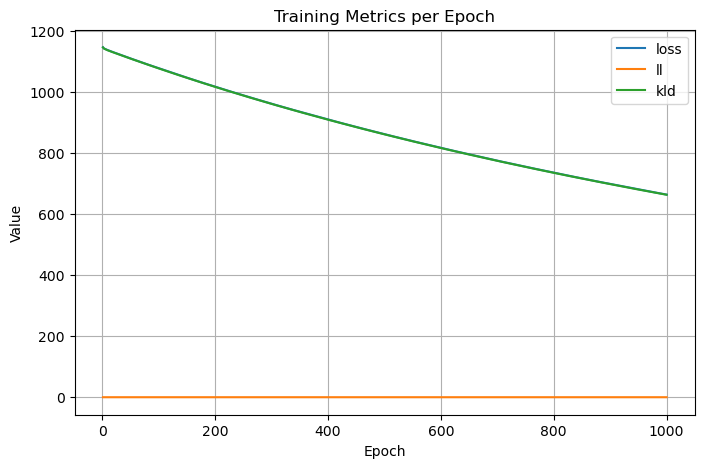

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Extract unique epochs
epochs = sorted(set(d['epoch'] for d in history))

# Compute average values per epoch
metrics = {m: [np.mean([d[m] for d in history if d['epoch'] == e]) for e in epochs] 
           for m in ['loss', 'll', 'kld']}

# Plot
plt.figure(figsize=(8, 5))
for metric, values in metrics.items():
    plt.plot(epochs, values, label=metric)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# prepare train data
train_bags = train_adata.obs["individualID"].unique().tolist()
Xs = [torch.Tensor(train_adata[train_adata.obs["individualID"] == bag].X) for bag in train_bags]
# F = torch.Tensor([[1 if sex_dict[bag] == 1 else 0] for bag in train_bags]) # fixed effects for sex
F = torch.ones((len(train_bags), 1))
Y = torch.Tensor(train_adata.obs[["individualID", "TRAPPC6A_twas_cat"]].drop_duplicates().set_index("individualID").loc[train_bags].values)

In [ ]:
# prepare test data, following official train-test split
test_bags = test_adata.obs["individualID"].unique().tolist()
test_Xs = [torch.Tensor(test_adata[test_adata.obs["individualID"] == bag].X) for bag in test_bags]
# test_F = torch.Tensor([[1 if test_sex_dict[bag] == 'Female' else 0] for bag in test_bags])
test_Y = torch.Tensor(test_adata.obs[["individualID", "TRAPPC6A_twas_cat"]].drop_duplicates().set_index("individualID").loc[test_bags].values)

In [ ]:
# initialize model with mean model and Bernoulli likelihood
# model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=2)
model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="categorical")
y_pred_mean = model.predict(test_Xs)
# y_pred_proba = torch.softmax(y_pred_mean, dim=1).numpy()
y_pred_labels = torch.argmax(y_pred_mean, dim=-1)
print(
    # "Test AUC:",
    # round(roc_auc_score(test_Y, y_pred_mean), 3),
    # "Spearman:",
    # round(st.spearmanr(test_Y, y_pred_mean).correlation, 3),
    "Spearman:",
    round(st.spearmanr(test_Y, y_pred_labels).correlation, 3),
    "Accuracy",
    round(accuracy_score(test_Y, y_pred_labels), 3),
)

In [ ]:
# train model for 1000 epochs
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, Xs, F, Y, test_Xs, test_Y = to_device((model, Xs, F, Y, test_Xs, test_Y), device)
history = model.train(Xs, F, Y, n_epochs=1000, 
                      # batch_size = 128, 
                      # lr = 1e-4,
                     )
model.to("cpu")
test_Xs = [x.cpu() for x in test_Xs]
# y_pred = model.predict(test_Xs).cpu().numpy()
y_pred = model.predict(test_Xs)
y_true = test_Y.cpu().numpy()
y_pred_labels = torch.argmax(y_pred, dim=-1).cpu().numpy()
print(
    # "Test AUC:",
    # round(roc_auc_score(y_true, y_pred), 3),
    # "Spearman:",
    # round(st.spearmanr(y_true, y_pred).correlation, 3),
    "Spearman:",
    round(st.spearmanr(y_true, y_pred_labels).correlation, 3),
    "Accuracy",
    round(accuracy_score(y_true, y_pred_labels), 3),
)

## APOE predictions

In [4]:
sample_key = 'individualID'
classification_keys = ["apoe_label"]
z_dim = 30
categorical_covariate_keys = classification_keys + [sample_key]
seed = 0

In [5]:
new_adata = ad.AnnData(X=adata.obsm['X_scVI'])
new_adata.obs = adata.obs.copy()
new_adata.obsm = adata.obsm.copy()

In [6]:
samples = np.unique(adata.obs[sample_key])
n_samples = len(samples)
query_proportion = 0.2
rng = np.random.default_rng(seed)
query_samples = rng.choice(samples, int(n_samples * query_proportion), replace=False)

# separate query and training adata
query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
adata = new_adata[~new_adata.obs[sample_key].isin(query_samples)].copy()
query.obs["ref"] = "query"
adata.obs["ref"] = "reference"

# sort index in both training adata and query 
idx = adata.obs[sample_key].sort_values().index
adata = adata[idx].copy()
idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

In [7]:
len(new_adata.obs[new_adata.obs['apoe_label']==0]['individualID'].unique())

332

In [8]:
len(new_adata.obs[new_adata.obs['apoe_label']==1]['individualID'].unique())

111

In [9]:
len(new_adata.obs[new_adata.obs['apoe_label']==2]['individualID'].unique())

6

In [10]:
new_adata.obs['individualID'].unique()

['R4119160', 'R4641987', 'R5693901', 'R9116123', 'R2670295', ..., 'R2246117', 'R4516201', 'R9938583', 'R6231318', 'R1933335']
Length: 449
Categories (449, object): ['R1015854', 'R1020037', 'R1028639', 'R1042011', ..., 'R9936070', 'R9938583', 'R9976232', 'R9996478']

In [11]:
train_adata = adata.copy()
test_adata = query.copy()

In [12]:
sex_dict = dict(zip(train_adata.obs['individualID'], train_adata.obs['msex']))

In [13]:
# test_sex_dict = dict(zip(test_adata.obs['Donor ID'], test_adata.obs['Sex']))

In [14]:
# train_adata.obs['Age at Death']

In [15]:
# prepare train data
train_bags = train_adata.obs["individualID"].unique().tolist()
Xs = [torch.Tensor(train_adata[train_adata.obs["individualID"] == bag].X) for bag in train_bags]
F = torch.Tensor([[1 if sex_dict[bag] == 1 else 0] for bag in train_bags]) # fixed effects for sex
Y = torch.Tensor(train_adata.obs[["individualID", "apoe_label"]].drop_duplicates().set_index("individualID").loc[train_bags].values)

In [16]:
# prepare test data, following official train-test split
test_bags = test_adata.obs["individualID"].unique().tolist()
test_Xs = [torch.Tensor(test_adata[test_adata.obs["individualID"] == bag].X) for bag in test_bags]
# test_F = torch.Tensor([[1 if test_sex_dict[bag] == 'Female' else 0] for bag in test_bags])
test_Y = torch.Tensor(test_adata.obs[["individualID", "apoe_label"]].drop_duplicates().set_index("individualID").loc[test_bags].values)

In [17]:
# initialize model with mean model and Bernoulli likelihood
# model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=2)
model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="categorical")
y_pred_mean = model.predict(test_Xs)
# y_pred_proba = torch.softmax(y_pred_mean, dim=1).numpy()
y_pred_labels = torch.argmax(y_pred_mean, dim=-1)
print(
    # "Test AUC:",
    # round(roc_auc_score(test_Y, y_pred_mean), 3),
    # "Spearman:",
    # round(st.spearmanr(test_Y, y_pred_mean).correlation, 3),
    "Spearman:",
    round(st.spearmanr(test_Y, y_pred_labels).correlation, 3),
    "Accuracy",
    round(accuracy_score(test_Y, y_pred_labels), 3),
)

/home/icb/zihe.zheng/miniconda3/envs/mixmil2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1905: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Spearman: 0.007 Accuracy 0.337


In [18]:
def to_device(el, device):
    """
    Move a nested structure of elements (dict, list, tuple, torch.Tensor, torch.nn.Module) to the specified device.

    Parameters:
    - el: Element or nested structure of elements to be moved to the device.
    - device (torch.device): The target device, such as 'cuda' for GPU or 'cpu' for CPU.

    Returns:
    - Transferred element(s) in the same structure: Elements moved to the specified device.
    """
    if isinstance(el, dict):
        return {k: to_device(v, device) for k, v in el.items()}
    elif isinstance(el, (list, tuple)):
        return [to_device(x, device) for x in el]
    elif isinstance(el, (torch.Tensor, torch.nn.Module)):
        return el.to(device)
    else:
        return el

In [19]:
# train model for 1000 epochs
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, Xs, F, Y, test_Xs, test_Y = to_device((model, Xs, F, Y, test_Xs, test_Y), device)
history = model.train(Xs, F, Y, n_epochs=1000, 
                      batch_size = 128, 
                      lr = 1e-4,
                     )
model.to("cpu")
test_Xs = [x.cpu() for x in test_Xs]
# y_pred = model.predict(test_Xs).cpu().numpy()
y_pred = model.predict(test_Xs)
y_true = test_Y.cpu().numpy()
y_pred_labels = torch.argmax(y_pred, dim=-1).cpu().numpy()
print(
    # "Test AUC:",
    # round(roc_auc_score(y_true, y_pred), 3),
    # "Spearman:",
    # round(st.spearmanr(y_true, y_pred).correlation, 3),
    "Spearman:",
    round(st.spearmanr(y_true, y_pred_labels).correlation, 3),
    "Accuracy",
    round(accuracy_score(y_true, y_pred_labels), 3),
)

Epoch: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [01:44<00:00,  9.54it/s]


Spearman: -0.029 Accuracy 0.348


In [20]:
# history

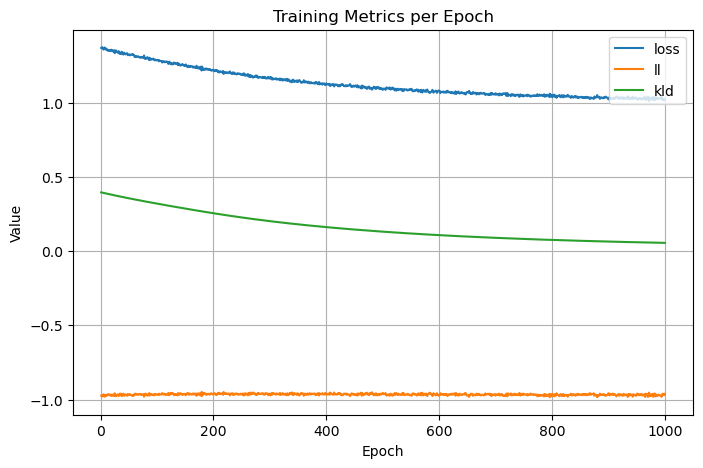

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Extract unique epochs
epochs = sorted(set(d['epoch'] for d in history))

# Compute average values per epoch
metrics = {m: [np.mean([d[m] for d in history if d['epoch'] == e]) for e in epochs] 
           for m in ['loss', 'll', 'kld']}

# Plot
plt.figure(figsize=(8, 5))
for metric, values in metrics.items():
    plt.plot(epochs, values, label=metric)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
Xs = to_device((Xs), 'cpu')
w, u = model.get_weights(Xs)

In [28]:
len(u[0].flatten().tolist())

4290

In [29]:
u[0]

tensor([[-0.2127, -1.0875, -0.7830],
        [ 0.1240,  0.4919,  0.3368],
        [ 0.0975,  0.3944, -0.0433],
        ...,
        [-0.4836, -1.4823, -0.1039],
        [-0.7474, -1.2959, -0.5746],
        [-0.2103, -1.0009, -0.4191]])

In [174]:
attn_list = []
for attn in u:
    attn = attn.flatten().tolist()
    attn_list.extend(attn)
train_adata.obs['attn_score'] = attn_list

ValueError: Length of values (3856239) does not match length of index (1285413)

In [ ]:
sc.pl.umap(train_adata, color = ['subset', 'attn_score'])

In [30]:
1285413*3

3856239

## Disease predictions

In [3]:
sample_key = 'individualID'
classification_keys = ["apoe_label"]
z_dim = 30
categorical_covariate_keys = classification_keys + [sample_key]
seed = 0

In [4]:
new_adata = ad.AnnData(X=adata.obsm['X_scVI'])
new_adata.obs = adata.obs.copy()
new_adata.obsm = adata.obsm.copy()

In [5]:
samples = np.unique(adata.obs[sample_key])
n_samples = len(samples)
query_proportion = 0.2
rng = np.random.default_rng(seed)
query_samples = rng.choice(samples, int(n_samples * query_proportion), replace=False)

# separate query and training adata
query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
adata = new_adata[~new_adata.obs[sample_key].isin(query_samples)].copy()
query.obs["ref"] = "query"
adata.obs["ref"] = "reference"

# sort index in both training adata and query 
idx = adata.obs[sample_key].sort_values().index
adata = adata[idx].copy()
idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

In [6]:
new_adata.obs['AD'] = new_adata.obs['AD'].astype(int)

In [7]:
len(new_adata.obs[new_adata.obs['AD']==True]['individualID'].unique())

290

In [8]:
len(new_adata.obs[new_adata.obs['AD']==False]['individualID'].unique())

159

In [9]:
train_adata = adata.copy()
test_adata = query.copy()

In [10]:
# prepare train data
train_bags = train_adata.obs["individualID"].unique().tolist()
Xs = [torch.Tensor(train_adata[train_adata.obs["individualID"] == bag].X) for bag in train_bags]
F = torch.ones((len(train_bags), 1))
Y = torch.Tensor(train_adata.obs[["individualID", "AD"]].drop_duplicates().set_index("individualID").loc[train_bags].values)

In [11]:
# prepare test data, following official train-test split
test_bags = test_adata.obs["individualID"].unique().tolist()
test_Xs = [torch.Tensor(test_adata[test_adata.obs["individualID"] == bag].X) for bag in test_bags]
test_Y = torch.Tensor(test_adata.obs[["individualID", "AD"]].drop_duplicates().set_index("individualID").loc[test_bags].values)

In [12]:
# initialize model with mean model and Bernoulli likelihood
model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=1)
y_pred_mean = model.predict(test_Xs)
print(
    "Test AUC:",
    round(roc_auc_score(test_Y, y_pred_mean), 3),
    "Spearman:",
    round(st.spearmanr(test_Y, y_pred_mean).correlation, 3),
)

GLMM Init: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Test AUC: 0.618 Spearman: 0.199


In [13]:
def to_device(el, device):
    """
    Move a nested structure of elements (dict, list, tuple, torch.Tensor, torch.nn.Module) to the specified device.

    Parameters:
    - el: Element or nested structure of elements to be moved to the device.
    - device (torch.device): The target device, such as 'cuda' for GPU or 'cpu' for CPU.

    Returns:
    - Transferred element(s) in the same structure: Elements moved to the specified device.
    """
    if isinstance(el, dict):
        return {k: to_device(v, device) for k, v in el.items()}
    elif isinstance(el, (list, tuple)):
        return [to_device(x, device) for x in el]
    elif isinstance(el, (torch.Tensor, torch.nn.Module)):
        return el.to(device)
    else:
        return el

In [14]:
# train model for 1000 epochs
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, Xs, F, Y, test_Xs, test_Y = to_device((model, Xs, F, Y, test_Xs, test_Y), device)
history = model.train(Xs, F, Y, n_epochs=1500, 
                      # batch_size = 16, 
                      # lr = 1e-5,
                     )
model.to("cpu")
test_Xs = [x.cpu() for x in test_Xs]
y_pred = model.predict(test_Xs).cpu().numpy()
y_true = test_Y.cpu().numpy()
print(
    "Test AUC:",
    round(roc_auc_score(y_true, y_pred), 3),
    "Spearman:",
    round(st.spearmanr(y_true, y_pred).correlation, 3),
)

Epoch: 100%|███████████████████████████████████████████████████████████████████████| 1500/1500 [03:21<00:00,  7.43it/s]


Test AUC: 0.824 Spearman: 0.545


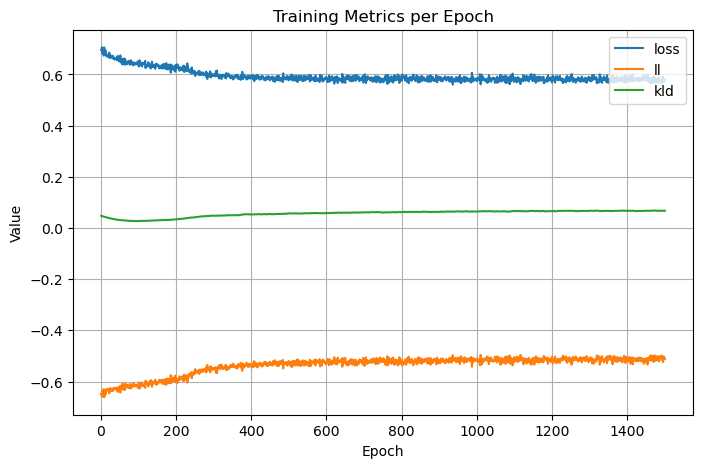

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract unique epochs
epochs = sorted(set(d['epoch'] for d in history))

# Compute average values per epoch
metrics = {m: [np.mean([d[m] for d in history if d['epoch'] == e]) for e in epochs] 
           for m in ['loss', 'll', 'kld']}

# Plot
plt.figure(figsize=(8, 5))
for metric, values in metrics.items():
    plt.plot(epochs, values, label=metric)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
Xs = to_device((Xs), 'cpu')

In [17]:
w, u = model.get_weights(Xs)

In [18]:
len(u)

360

In [19]:
train_adata

AnnData object with n_obs × n_vars = 1285413 × 30
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', '_scvi_batch', '_scvi_labels', 'AD', 'apoe_label', 'ref'
    obsm: 'X_pca', 'X_scVI', 'X_umap'

In [20]:
attn_list = []
for attn in u:
    attn = attn.flatten().tolist()
    attn_list.extend(attn)
train_adata.obs['attn_score'] = attn_list

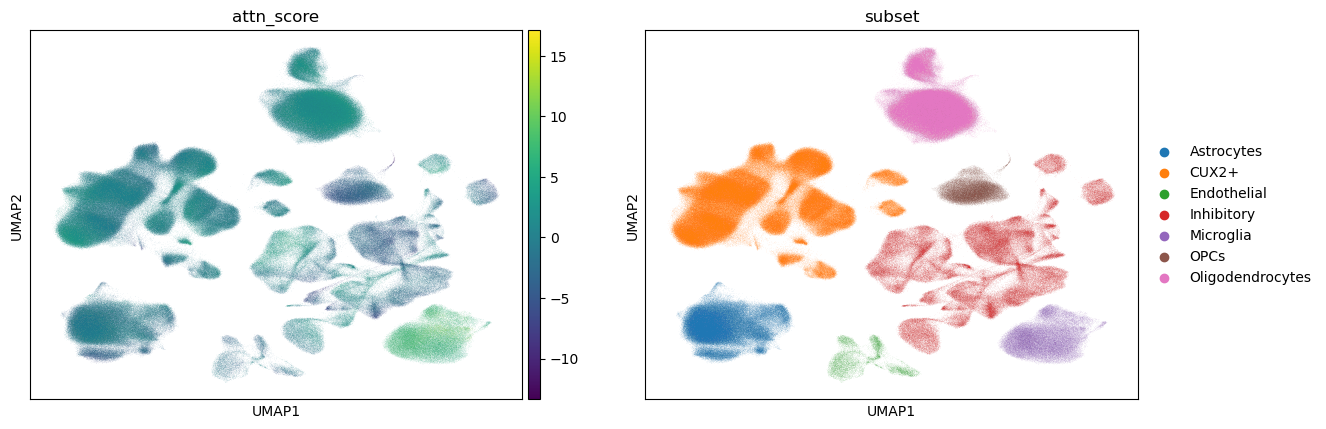

In [22]:
sc.pl.umap(train_adata, color = ['attn_score', 'subset'])

In [95]:
adata.obs.subset.unique()

['Inhibitory', 'CUX2+', 'Astrocytes', 'Oligodendrocytes', 'Endothelial', 'Microglia', 'OPCs']
Categories (7, object): ['Astrocytes', 'CUX2+', 'Endothelial', 'Inhibitory', 'Microglia', 'OPCs', 'Oligodendrocytes']